In [29]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os

import utils.datasets as datasets
import utils.sde_lib as sdes
from utils.models import MLP
from utils.misc import dotdict, batch_matrix_product

torch.set_printoptions(precision=3,sci_mode=False)

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
is_sb = True
if is_sb:
    model_path = './checkpoints/spiral_sb_linear/itr_2000'
    backward_score = torch.load(os.path.join(model_path,'backward_ema_2000.pt'))
else:
    model_path = './checkpoints/spiral_vp/itr_30000'
    backward_score = torch.load(os.path.join(model_path,'backward_ema_30000.pt'))
    
sde = sdes.VP(model_backward=backward_score)
if is_sb:
    forward_score = torch.load(os.path.join(model_path,'forward_ema_2000.pt'))
    sde = sdes.SchrodingerBridge(forward_score,backward_score)

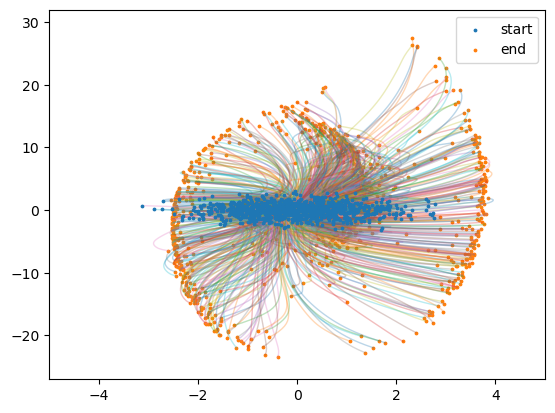

In [31]:
dataset = datasets.Spiral(x_scalar=.4, y_scalar=3.2)
n_samples = 1000
in_cond = dataset.sample(n_samples).to(device=device)
xt, traj = sde.sample((n_samples,2), device, backward=True, in_cond=in_cond,prob_flow=True)

for i in range(traj.shape[1]):
    xi = traj[:,i]
    plt.xlim(-5,5)
    plt.ylim(-27,32)
    plt.scatter(xi[:,0].cpu(), xi[:,1].cpu())
    plt.savefig(f'./trajectory/{i}.png')
    plt.clf()



for i in range(traj.shape[0]):
    xi = traj[i]
    plt.plot(xi[:,0].cpu(), xi[:,1].cpu(), linewidth=1, alpha=.3)

plt.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(),s=3, label='start',zorder=1010)
plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(), s=3,label='end')
plt.xlim(-5,5)
plt.ylim(-27,32)
plt.legend()
plt.show()

In [32]:
n_pts = 20
x_pts = torch.linspace(-5,5,n_pts,device=device)#.view(-1,1)
y_pts = torch.linspace(-27,32,n_pts, device=device)#.view(-1,1)
x_pts, y_pts = torch.meshgrid((x_pts,y_pts))
x_pts = x_pts.reshape(-1,1)
y_pts = y_pts.reshape(-1,1)
z_pts = torch.cat((x_pts,y_pts),dim=-1)
n_time = 100
times = torch.linspace(0,1,n_time,device=device).unsqueeze(-1)
dt = 1/n_time
xt = dataset.sample(1000).to(device=device)
noise = torch.randn_like(xt)
for i,t in enumerate(times):
    t_shape = t.expand(z_pts.shape[0]).unsqueeze(-1)
    
    vector_field = sde.probability_flow_drift(z_pts,t_shape)
    plt.xlim(-5,5)
    plt.ylim(-27,32)
    plt.quiver(x_pts.cpu(),y_pts.cpu(),vector_field[:,0].cpu(),vector_field[:,1].cpu())
    plt.scatter(xt[:,0].cpu(), xt[:,1].cpu(),alpha=.3)
    plt.scatter(noise[:,0].cpu(), noise[:,1].cpu(),alpha=.1)
    plt.savefig(f'./vector-field/{i}.png')
    plt.clf()
    xt = xt + sde.probability_flow_drift(xt,t.expand(xt.shape[0]).unsqueeze(-1)) * dt


<Figure size 640x480 with 0 Axes>

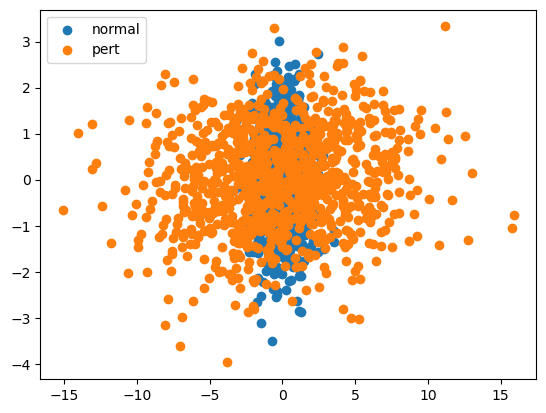

In [36]:
L = torch.tensor([[4.5026, 0.1263],
        [0.1263, 1.1072]], device='cuda:0')

noise = torch.randn((1000,2), device=device)
noise_pert = (L @ noise.T).T
plt.scatter(noise[:,0].cpu(), noise[:,1].cpu(), label='normal')
plt.scatter(noise_pert[:,0].cpu(), noise_pert[:,1].cpu(), label='pert')
plt.legend()
plt.show()